In [1]:
import os
import tempfile
import time
import numpy as np
import faiss
import h5py
import requests
from collections import defaultdict
import bisect
import matplotlib.pyplot as plt

In [2]:
# --- Data Utilities ---

def download_fashion_mnist(cache_path, url):
    if not os.path.exists(cache_path):
        print("Downloading Fashion-MNIST (~300 MB)…")
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            with open(cache_path, "wb") as f:
                f.write(response.content)
        else:
            raise Exception(f"Failed to download dataset: HTTP{response.status_code}")

def load_fashion_mnist(cache_path):
    with h5py.File(cache_path, "r") as f:
        xb = f["train"][:].astype(np.float32)
        xq = f["test"][:].astype(np.float32)
        gt = f["neighbors"][:]
    return xb, xq, gt

In [ ]:
# --- Indexing Utilities ---

def build_kmeans(xb, d, n_clusters, niter=20):
    train_sample = xb[np.random.choice(len(xb), size=min(50000, len(xb)), replace=False)]
    kmeans = faiss.Kmeans(d, n_clusters, niter=niter, verbose=True, spherical=False)
    kmeans.train(train_sample)
    return kmeans

def assign_vectors_to_clusters(xb, kmeans, n_assign):
    _, assignments = kmeans.index.search(xb, n_assign)
    return assignments

def cross_pollinate_metadata(xb, xb_inner_assignments, inner_centroids, inner_to_outer, N_CROSS):
    # vector_metadata is a nested dictionary:onary: is a nested dictionary:
    # vector_metadata[outer_id][inner_id] = list of tuples (dist, cos_sim, idx)
    # where:
    #   - outer_id: ID of the outer cluster
    # ID of the   - inner cluster inner_id: ID of the inner cluster
    #   - dist: Euclidean distance from vector to inner centroid distance from vector to inner centroid
    #   - cos_sim: Cosine similarity between vector and inner centroidor and inner centroid
    #   - idx: index of the vector in xb

    vector_metadata = defaultdict(dict)
    for idx, inner_ids in enumerate(xb_inner_assignments):
        # For each vector, assign it to the first N_CROSS inner clusters
        for inner_id in inner_ids[:N_CROSS]:
            # Find the corresponding outer cluster for this inner cluster
            outer_id = inner_to_outer[inner_id][0]
            # Get the centroid of the inner cluster
            centroid = inner_centroids[inner_id]
            # Get the vector itself
            vec = xb[idx]
            # Compute Euclidean distance from vector to centroid
            dist = np.linalg.norm(vec - centroid)
            # Compute cosine similarity between vector and centroid
            cos_sim = np.dot(vec, centroid) / (np.linalg.norm(vec) * np.linalg.norm(centroid) + 1e-8)
            # Store (distance, cosine similarity, vector index) in the metadata
            vector_metadata[outer_id].setdefault(inner_id, []).append((dist, cos_sim, idx))
    vector_metadata = defaultdict(dict)
    # Sort each list by Euclidean distance to centroid
    for outer_id in vector_metadata:
        for inner_id in vector_metadata[outer_id]:
            vector_metadata[outer_id][inner_id].sort()
    return vector_metadata

def build_outer_to_num_inner_clusters(vector_metadata):
    """
    Build a dictionary mapping each outer cluster id to the number of inner clusters it contains.
    Args:
        vector_metadata: dict[outer_id][inner_id] -> list of vectors
    Returns:
        outer_to_num_inner_clusters: dict[outer_id] -> int (number of inner clusters)
    """
    outer_to_num_inner_clusters = {}
    for outer_id in vector_metadata:
        outer_to_num_inner_clusters[outer_id] = len(vector_metadata[outer_id])

    print("\nNumber of inner clusters for each outer cluster:")
    for outer_id in sorted(outer_to_num_inner_clusters):
        print(f"Outer cluster {outer_id}: {outer_to_num_inner_clusters[outer_id]} inner clusters")
    return outer_to_num_inner_clusters

In [ ]:
# --- Search Utilities ---
# Pads the input array/list to length k with pad_value if necessary.
def pad_to_k(arr, k, pad_value):
    arr = list(arr)
    if len(arr) < k:
        arr += [pad_value] * (k - len(arr))
    return arr[:k]

def search_query_cross_pollination_nprobe(
    x, outer_ids, inner_kmeans, vector_metadata, xb, k, d,
    N_PROBE=1, n_outer_total=10
):
    best_heap = []
    tau = float("inf")
    inner_probed = 0
    seen_indices = set()
    outer_idx = 0
    total_outer = len(outer_ids)
    # probed_inner_ids = set()
    while inner_probed < N_PROBE and outer_idx < total_outer:
        # Probe the next outer cluster and select inner clusters to probe based on L2 distance to the query.
        outer_id = outer_ids[outer_idx]
        outer_idx += 1
        if outer_id not in vector_metadata:
            continue
        inner_ids = list(vector_metadata[outer_id].keys())
        if not inner_ids:
            continue
        # n_inner_probe = min(N_PROBE - inner_probed, len(inner_ids))
        # inner_ids_to_probe = [iid for iid in inner_ids if iid not in probed_inner_ids][:n_inner_probe]
        # if not inner_ids_to_probe:
        #   continue
        inner_centroids_subset = inner_kmeans.centroids[inner_ids]
        index_l2 = faiss.IndexFlatL2(d)
        index_l2.add(inner_centroids_subset)
        _, inner_ranks_local = index_l2.search(x.reshape(1, -1), N_PROBE)
        selected_inner_ids = [inner_ids[j] for j in inner_ranks_local[0] if j < len(inner_ids)]
        for inner_id in selected_inner_ids:
            # probed_inner_ids.add(inner_id)
            idxs_meta = vector_metadata[outer_id][inner_id]
            if not idxs_meta:
                continue
            centroid = inner_kmeans.centroids[inner_id]
            d_qc = np.linalg.norm(x - centroid)
            for dist_ic, cos_theta, idx2 in idxs_meta:
                if idx2 in seen_indices:
                    continue
                # Lower bound pruning: skip if the minimum possible distance exceeds current tau
                lower_bound = abs(d_qc - dist_ic)
                if lower_bound > tau:
                    continue
                # Estimate the distance between the query and the candidate using the law of cosines
                est_dist = np.sqrt(max(0.0, d_qc ** 2 + dist_ic ** 2 - 2 * d_qc * dist_ic * cos_theta))
                if est_dist > tau:
                    continue
                actual_dist = np.linalg.norm(x - xb[idx2])
                best_heap.append((actual_dist, idx2))
                seen_indices.add(idx2)
                if len(best_heap) > k:
                    best_heap.sort()
                    best_heap = best_heap[:k]
                    # Update tau to the current worst (largest) distance in the heap
                    tau = best_heap[-1][0]
            inner_probed += 1
            if inner_probed >= N_PROBE:
                break
    return best_heap

def search_query_cross_pollination_tshirt(
    x, outer_ids, inner_kmeans, vector_metadata, xb, k, d,
    tshirt_size="small", n_outer_total=10
):
    tshirt_settings = {
        "small": 0.10,
        "medium": 0.20,
        "large": 0.30
    }
    best_heap = []
    tau = float("inf")
    probed_inner_ids = set()
    seen_indices = set()
    pct = tshirt_settings[tshirt_size]
    n_outer_probe = max(1, int(np.ceil(n_outer_total * pct)))
    outer_ids = outer_ids[:n_outer_probe]
    for outer_id in outer_ids:
        if outer_id not in vector_metadata:
            continue
        inner_ids = list(vector_metadata[outer_id].keys())
        if not inner_ids:
            continue
        n_inner_probe = max(1, int(np.ceil(len(inner_ids) * pct)))
        inner_ids_to_probe = [iid for iid in inner_ids if iid not in probed_inner_ids][:n_inner_probe]
        if not inner_ids_to_probe:
            continue
        inner_centroids_subset = inner_kmeans.centroids[inner_ids_to_probe]
        index_l2 = faiss.IndexFlatL2(d)
        index_l2.add(inner_centroids_subset)
        _, inner_ranks_local = index_l2.search(x.reshape(1, -1), len(inner_ids_to_probe))
        selected_inner_ids = [inner_ids_to_probe[j] for j in inner_ranks_local[0] if j < len(inner_ids_to_probe)]
        for inner_id in selected_inner_ids:
            probed_inner_ids.add(inner_id)
            idxs_meta = vector_metadata[outer_id][inner_id]
            if not idxs_meta:
                continue
            centroid = inner_kmeans.centroids[inner_id]
            d_qc = np.linalg.norm(x - centroid)
            for dist_ic, cos_theta, idx2 in idxs_meta:
                if idx2 in seen_indices:
                    continue
                lower_bound = abs(d_qc - dist_ic)
                if lower_bound > tau:
                    continue
                est_dist = np.sqrt(max(0.0, d_qc ** 2 + dist_ic ** 2 - 2 * d_qc * dist_ic * cos_theta))
                if est_dist > tau:
                    continue
                actual_dist = np.linalg.norm(x - xb[idx2])
                best_heap.append((actual_dist, idx2))
                seen_indices.add(idx2)
                if len(best_heap) > k:
                    best_heap.sort()
                    best_heap = best_heap[:k]
                    tau = best_heap[-1][0]
    return best_heap

# Wrapper function to select the probing strategy for cross-pollination search.
def search_query_cross_pollination(
    x, outer_ids, inner_kmeans, vector_metadata, xb, k, d,
    N_PROBE=1, probe_strategy="nprobe", tshirt_size="small", n_outer_total=10
):
    if probe_strategy == "nprobe":
        return search_query_cross_pollination_nprobe(
            x, outer_ids, inner_kmeans, vector_metadata, xb, k, d,
            N_PROBE=N_PROBE, n_outer_total=n_outer_total
        )
    else:
        return search_query_cross_pollination_tshirt(
            x, outer_ids, inner_kmeans, vector_metadata, xb, k, d,
            tshirt_size=tshirt_size, n_outer_total=n_outer_total
        )

def search_all_queries_cross_pollination(
    xq, xq_outer_assignments, inner_kmeans, vector_metadata, xb, k, d, gt,
    N_PROBE=1, probe_strategy="nprobe", tshirt_size="small", n_outer_total=10
):
    I = []
    D = []
    start_time = time.time()
    for i, x in enumerate(xq):
        outer_ids = xq_outer_assignments[i]
        best_heap = search_query_cross_pollination(
            x, outer_ids, inner_kmeans, vector_metadata, xb, k, d,
            N_PROBE=N_PROBE, probe_strategy=probe_strategy, tshirt_size=tshirt_size, n_outer_total=n_outer_total
        )
        if best_heap:
            best_heap.sort()
            idxs = [idx for _, idx in best_heap]
            dists = [dist for dist, _ in best_heap]
            I.append(pad_to_k(idxs, k, -1))  # Use -1 or another invalid index as pad
            D.append(pad_to_k(dists, k, float('inf')))
        else:
            dists = np.linalg.norm(xb - x.reshape(1, -1), axis=1)
            idx = np.argsort(dists)[:k]
            I.append(idx)
            D.append(dists[idx])
    D = np.array(D)
    I = np.array(I)
    elapsed_time = time.time() - start_time
    qps = len(xq) / elapsed_time
    recall = np.mean([
        len(set(I[i]) & set(gt[i, :k])) / k
        for i in range(gt.shape[0])
    ])
    return I, D, recall, qps                                  

In [5]:
# --- Experiment Utilities ---

def evaluate_cross_pollination(
    xb, xq, gt, inner_kmeans, inner_to_outer, xq_outer_assignments, k, d,
    N_PROBE=1, min_cross=1, max_cross=5, probe_strategy="nprobe", tshirt_size="small", n_outer_total=10
):
    recalls = []
    qps_list = []
    cross_range = range(min_cross, max_cross + 1)
    inner_centroids = inner_kmeans.centroids
    for N_CROSS in cross_range:
        print(f"Evaluating N_CROSS = {N_CROSS}")
        xb_inner_assignments = assign_vectors_to_clusters(xb, inner_kmeans, N_CROSS)
        vector_metadata = cross_pollinate_metadata(
            xb, xb_inner_assignments, inner_centroids, inner_to_outer, N_CROSS
        )
        build_outer_to_num_inner_clusters(vector_metadata)
        I, D, recall, qps = search_all_queries_cross_pollination(
            xq, xq_outer_assignments, inner_kmeans, vector_metadata, xb, k, d, gt,
            N_PROBE=N_PROBE, probe_strategy=probe_strategy, tshirt_size=tshirt_size, n_outer_total=n_outer_total
        )
        recalls.append(recall)
        qps_list.append(qps)
        print(f"N_CROSS={N_CROSS}: recall={recall:.4f}, qps={qps:.2f}")
    return cross_range, recalls, qps_list

def plot_cross_pollination_results(cross_range, recalls, qps_list):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('N_CROSS (number of clusters each vector is inserted into)')
    ax1.set_ylabel('Recall', color=color)
    ax1.plot(cross_range, recalls, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('QPS', color=color)
    ax2.plot(cross_range, qps_list, marker='x', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title('Recall and QPS vs N_CROSS (cross-pollination)')
    plt.show()


In [6]:
def run_cross_pollination_experiment(
    dataset_path,
    n_inner_clusters=400,
    probe_strategy="nprobe",
    N_PROBE=2,
    min_cross=1,
    max_cross=6,
    tshirt_size="small"
):
    # Load data
    xb, xq, gt = load_fashion_mnist(dataset_path)
    d = xb.shape[1]
    k = 10

    # Build KMeans
    inner_kmeans = build_kmeans(xb, d, n_inner_clusters)
    inner_centroids = inner_kmeans.centroids

    outer_kmeans = build_kmeans(inner_centroids, d, 10)
    _, inner_to_outer = outer_kmeans.index.search(inner_centroids, 1)
    _, xq_outer_assignments = outer_kmeans.index.search(xq, 3)

    # Evaluate cross-pollination
    cross_range, recalls, qps_list = evaluate_cross_pollination(
        xb, xq, gt, inner_kmeans, inner_to_outer, xq_outer_assignments, k, d,
        N_PROBE=N_PROBE, min_cross=min_cross, max_cross=max_cross, probe_strategy=probe_strategy,
        tshirt_size=tshirt_size, n_outer_total=10
    )

    # Plot results
    plot_cross_pollination_results(cross_range, recalls, qps_list)
    return cross_range, recalls, qps_list


=== Running experiment for fashion-mnist ===
Sampling a subset of 25600 / 50000 for training
Clustering 25600 points in 784D to 100 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.51 s, search 0.43 s): objective=3.3706e+10 imbalance=1.118 nsplit=0        
Clustering 100 points in 784D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.00 s): objective=1.02436e+08 imbalance=1.070 nsplit=0       
Evaluating N_CROSS = 4


WARNING clustering 100 points to 10 centroids: please provide at least 390 training points



Number of inner clusters for each outer cluster:
Outer cluster 0: 12 inner clusters
Outer cluster 1: 7 inner clusters
Outer cluster 2: 13 inner clusters
Outer cluster 3: 9 inner clusters
Outer cluster 4: 8 inner clusters
Outer cluster 5: 7 inner clusters
Outer cluster 6: 15 inner clusters
Outer cluster 7: 9 inner clusters
Outer cluster 8: 8 inner clusters
Outer cluster 9: 12 inner clusters
N_CROSS=4: recall=0.9535, qps=72.03
Evaluating N_CROSS = 5

Number of inner clusters for each outer cluster:
Outer cluster 0: 12 inner clusters
Outer cluster 1: 7 inner clusters
Outer cluster 2: 13 inner clusters
Outer cluster 3: 9 inner clusters
Outer cluster 4: 8 inner clusters
Outer cluster 5: 7 inner clusters
Outer cluster 6: 15 inner clusters
Outer cluster 7: 9 inner clusters
Outer cluster 8: 8 inner clusters
Outer cluster 9: 12 inner clusters
N_CROSS=5: recall=0.9700, qps=58.32
Evaluating N_CROSS = 6

Number of inner clusters for each outer cluster:
Outer cluster 0: 12 inner clusters
Outer clu

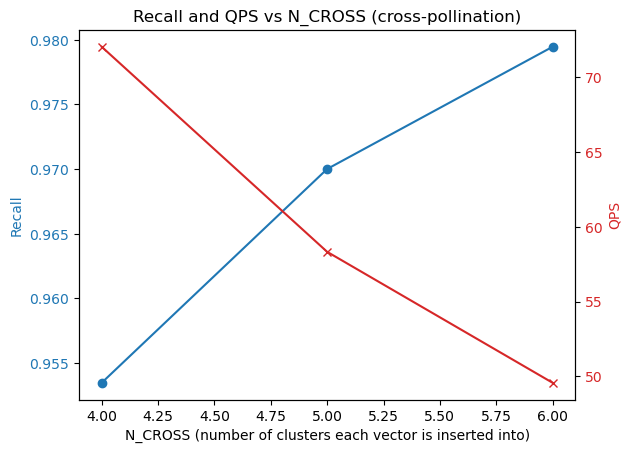

(range(4, 7),
 [0.9534799999999999, 0.9700099999999998, 0.97946],
 [72.03085580954041, 58.32235910031325, 49.56807929826236])

In [ ]:
# --- Main Execution ---
# Build index based on euclidean distance
# Specify which dataset to use: "fashion-mnist", "gist", or "sift"
selected_dataset = "fashion-mnist"

DATA_URLS = {
    "fashion-mnist": "http://ann-benchmarks.com/fashion-mnist-784-euclidean.hdf5",
    "gist": "http://ann-benchmarks.com/gist-960-euclidean.hdf5",
    "sift": "http://ann-benchmarks.com/sift-128-euclidean.hdf5"
}
CACHES = {
    name: os.path.join(tempfile.gettempdir(), url.split('/')[-1])
    for name, url in DATA_URLS.items()
}

# Download the selected dataset if not present
cache_path = CACHES[selected_dataset]
download_fashion_mnist(cache_path, DATA_URLS[selected_dataset])

# Run cross-pollination experiment for the selected dataset
print(f"\n=== Running experiment for {selected_dataset} ===")
run_cross_pollination_experiment(
    dataset_path=cache_path,
    n_inner_clusters=100,
    probe_strategy="nprobe",
    N_PROBE=1,
    min_cross=1,
    max_cross=6,
    tshirt_size="small"
)